Acknowledgment: AI assisted in the development of the code used in this project. Because AI support was integrated throughout the coding process, it is difficult to isolate which components were written entirely without AI assistance. All architectural and design decisions were made by the authors, who explicitly guided the AI through each stage of model construction rather than relying on the AI to direct the design.

Instructions to run the code: The code is simple to run, simply click on Run all, and each model will run when its section is reached, as broken and organized in the file.

In [ ]:
from datasets import load_dataset
import pandas as pd
import random
import json
import math

In [ ]:
ds = load_dataset("arbml/Arabic_Dialects_Dataset")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/445 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9992 [00:00<?, ? examples/s]

In [ ]:
print(ds)
print(ds['train'].column_names)
print(ds['train'][0])

DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 9992
    })
})
['Text', 'label']
{'Text': 'شأني تلتها ستحظى أه يا خير الدين ولكن أه', 'label': 1}


In [ ]:
df = ds['train'].to_pandas()


### Normalization over the text columns due to Arabic having multiple variations of single letters (eg. أ إ آ should be treated the same)

In [ ]:
import re
# This code snippet was supported by AI
arabic_diacritics = re.compile(r"[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]")

def normalize_arabic(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r"[ـ]+", "", text)
    text = arabic_diacritics.sub("", text)
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ى", "ي")
    text = text.replace("ؤ", "و").replace("ئ", "ي")
    text = re.sub(r"[^\w\s\u0600-\u06FF]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
df["Text"] = df["Text"].apply(normalize_arabic)


In [ ]:
def word_count(text):
    return len(text.split())

df = df[df["Text"].apply(word_count) >= 2].reset_index(drop=True)

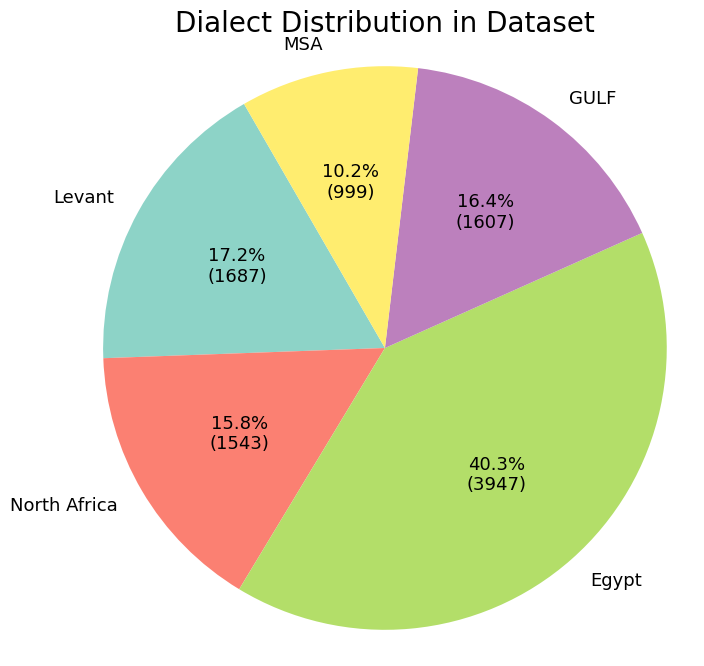

In [ ]:
# beautiful graphing
# This code snippet was supported by AI to graph
label_names = ds["train"].features["label"].names
import pandas as pd

counts = df["label"].value_counts().sort_index()
import matplotlib.pyplot as plt
import numpy as np

counts = df["label"].value_counts().sort_index()
sizes = counts.values
labels = label_names

colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

def make_autopct(values):
    def inner_autopct(percent):
        absolute = int(round(percent * np.sum(values) / 100))
        return f"{percent:.1f}%\n({absolute})"
    return inner_autopct

plt.figure(figsize=(8, 8))

plt.pie(
    sizes,
    labels = labels,
    autopct = make_autopct(sizes),
    startangle = 120,
    colors = colors,
    textprops = {"fontsize": 13}
)

plt.title("Dialect Distribution in Dataset", fontsize=20)
plt.axis("equal")

plt.show()




addtionally, might help to delete rows where only one word exists, and add weighting to deal with data imbalance

# 1. Baseline model

### After normalizing, we split into train, validation, and test - since dataset is small, we choose 10% test 10% validation and 80% train.








In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.10,
    stratify=train_df["label"],
    random_state=42
)

After splitting, initialize the TF-IDF and vectorize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=40000,
    lowercase=False
)

X_train = vectorizer.fit_transform(train_df["Text"])
X_val = vectorizer.transform(val_df["Text"])
X_test = vectorizer.transform(test_df["Text"])

y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]


In [ ]:
# This code snippet was supported by AI
# tune on c
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Tuning C values")
best_C = None
best_val_acc = 0

for C_val in [2, 3.0,3.2, 3.4, 3.7, 4.4, 5, 7]:
    temp_clf = LogisticRegression(max_iter = 300, C = C_val, n_jobs = -1)
    temp_clf.fit(X_train, y_train)
    val_acc = accuracy_score(y_val, temp_clf.predict(X_val))
    print("C =", C_val, "Validation accuracy =", val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C_val

print("Best C =", best_C)


Tuning C values
C = 2 Validation accuracy = 0.757094211123723
C = 3.0 Validation accuracy = 0.7639046538024972
C = 3.2 Validation accuracy = 0.7639046538024972
C = 3.4 Validation accuracy = 0.7616345062429057
C = 3.7 Validation accuracy = 0.7616345062429057
C = 4.4 Validation accuracy = 0.7616345062429057
C = 5 Validation accuracy = 0.7627695800227015
C = 7 Validation accuracy = 0.7604994324631101
Best C = 3.0


train the model

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=200,
    C=best_C,
    n_jobs=-1
)

clf.fit(X_train, y_train)


LogisticRegression(C=3.0, max_iter=200, n_jobs=-1)

evaluate

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print("Validation accuracy:", accuracy_score(y_val, clf.predict(X_val)))
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))


Validation accuracy: 0.7639046538024972
Test accuracy: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       169
           1       0.68      0.62      0.65       154
           2       0.86      0.98      0.92       395
           3       0.60      0.57      0.58       161
           4       0.80      0.65      0.72       100

    accuracy                           0.76       979
   macro avg       0.73      0.69      0.71       979
weighted avg       0.76      0.76      0.76       979



In [ ]:
label_names = ds["train"].features["label"].names


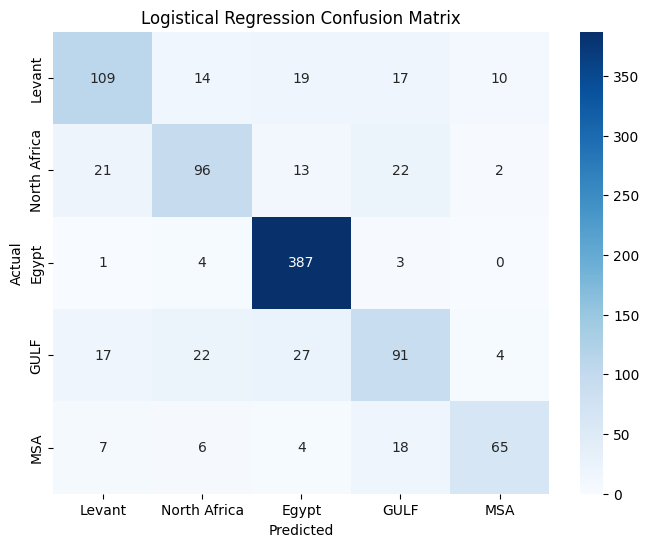

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistical Regression Confusion Matrix")
plt.show()


manual input

In [ ]:
label_names = ds["train"].features["label"].names
print(label_names)

['Levant', 'North Africa', 'Egypt', 'GULF', 'MSA']


In [ ]:
def predict_sentence(text):
    text = normalize_arabic(text)
    vec = vectorizer.transform([text])
    pred = clf.predict(vec)[0]
    return pred

example = "ماذا تريد ان اقدم لك؟"
print("Predicted dialect:", label_names[predict_sentence(example)])

Predicted dialect: MSA


# 2. Neural Network Model


In [ ]:
# tokenize with max vocab =30k
import torch
from collections import Counter

TEXT_COL = "Text"
LABEL_COL = "label"


def tokenize(text):
    return text.split()

counter = Counter()
for sent in train_df[TEXT_COL]:
    tokens = tokenize(sent)
    counter.update(tokens)

max_vocab_size = 30000

vocab = {"<pad>": 0, "<unk>": 1}
for token, freq in counter.most_common(max_vocab_size - len(vocab)):
    vocab[token] = len(vocab)

vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 30000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# This code snippet was supported by AI
class DialectDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return torch.tensor(self.input_ids[index]), torch.tensor(self.labels[index])

In [ ]:
# This code was based on CNN_Better from 5.4 multi-layer cnns.ipynb and some
# support from AI regarding on how we could fit it on our task
class DialectCNN_Simple(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes=5, pad_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx
        )

        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        #self.conv3 = nn.Conv1d(128, 128, kernel_size=3)
        #self.conv4 = nn.Conv1d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool1d(kernel_size=2)


        self.final_len = None
        self.dropout = nn.Dropout(0.5)

        self.fc1 = None
        self.fc2 = None

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = x.permute(0, 2, 1)

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))

        #x = F.relu(self.conv3(x))

        #x = F.relu(self.conv4(x))


        if self.final_len is None:
            self.final_len = x.shape[1] * x.shape[2]
            self.fc1 = nn.Linear(self.final_len, 256).to(x.device)
            self.fc2 = nn.Linear(256, 5).to(x.device)

        x = x.view(x.size(0), self.final_len)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# This code was based on on train functtion from 5.4 multi-layer cnns.ipynb and some
# support from AI regarding on how we could fit it on our task
def train(model, data_generator, loss_function, optimizer, device, batch_logging=100):
    model.train()
    avg_loss = 0
    num_batches = 0
    all_preds = []
    all_targets = []

    for batch_idx, (input_ids, target_output) in enumerate(data_generator):
        input_ids = input_ids.to(device)
        target_output = target_output.to(device)

        optimizer.zero_grad()
        prediction = model(input_ids)
        loss = loss_function(prediction, target_output)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        num_batches += 1

        preds = prediction.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(target_output.cpu().tolist())

        if (batch_idx + 1) % batch_logging == 0:
            print(
                "Batch [%d/%d], Train Loss: %.4f"
                % (batch_idx + 1, len(data_generator), avg_loss / num_batches)
            )

    epoch_loss = avg_loss / num_batches
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_macro_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_macro_f1



@torch.no_grad()
def evaluate(model, data_loader, loss_function, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    preds = []
    targets = []

    for input_ids, labels in data_loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids)
        loss = loss_function(outputs, labels)

        total_loss += loss.item()
        num_batches += 1

        predicted = outputs.data.max(1, keepdim=False)[1]

        preds.extend(predicted.cpu().tolist())
        targets.extend(labels.cpu().tolist())

    avg_loss = total_loss / num_batches
    acc = accuracy_score(targets, preds)
    macro_f1 = f1_score(targets, preds, average="macro")

    return avg_loss, acc, macro_f1, preds, targets


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device,", device)


Using device, cuda


In [ ]:
 # when encoding, if the word isn't in the most common vocab, we set it to unk
def encode_sentence(text, vocab, max_len):
    tokens = tokenize(text)
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    ids = ids[:max_len]
    pad_len = max_len - len(ids)
    if pad_len > 0:
        ids = ids + [vocab["<pad>"]] * pad_len
    return ids


In [ ]:
max_len = 30

train_ids = [encode_sentence(text, vocab, max_len) for text in train_df["Text"]]
val_ids = [encode_sentence(text, vocab, max_len) for text in val_df["Text"]]
test_ids = [encode_sentence(text, vocab, max_len) for text in test_df["Text"]]

train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()
test_labels = test_df["label"].tolist()
pad_idx = vocab["<pad>"]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# This code snippet was supported by AI
embed_dim = 100
batch_size = 64
lr = 1e-3
epochs = 25

train_dataset = DialectDataset(train_ids, train_labels)
val_dataset = DialectDataset(val_ids, val_labels)
test_dataset = DialectDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = DialectCNN_Simple(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    pad_idx=pad_idx
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

best_val = 99999999999999
patience = 8
wait = 0

print("Training begins")

for epoch in range(epochs):
    train_loss, train_acc, train_f1 = train(
    model,
    train_loader,
    loss_fn,
    optimizer,
    device
    )
    val_loss, val_acc, val_f1, _, _= evaluate(model, val_loader, loss_fn, device)


    print(f"Epoch {epoch + 1}")
    print(f"Train loss {train_loss}  Train acc {train_acc}  Train F1 {train_f1}")
    print(f"Val loss {val_loss}  Val acc {val_acc}  Val F1 {val_f1}")

    if val_loss < best_val:
        best_val = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

print("Evaluating on test set")

test_loss, test_acc, test_f1, preds, targets = evaluate(model, test_loader, loss_fn, device)

print(f"Test loss {test_loss}")
print(f"Test acc {test_acc}")
print(f"Test macro F1 {test_f1}")

cm = confusion_matrix(targets, preds)
print("Confusion matrix")
print(cm)

Training begins
Batch [100/124], Train Loss: 1.5206
Epoch 1
Train loss 1.5062842638261857  Train acc 0.4024990533888679  Train F1 0.11583259649345637
Val loss 1.423268164907183  Val acc 0.4029511918274688  Val F1 0.11488673139158576
Batch [100/124], Train Loss: 1.3617
Epoch 2
Train loss 1.3438822559772  Train acc 0.4206739871260886  Train F1 0.16988378769249218
Val loss 1.2469191210610526  Val acc 0.4767309875141884  Val F1 0.28590255356298167
Batch [100/124], Train Loss: 1.1632
Epoch 3
Train loss 1.1631578918426269  Train acc 0.49185914426353655  Train F1 0.31101493698414234
Val loss 1.1132779206548418  Val acc 0.5232690124858116  Val F1 0.3490366415730631
Batch [100/124], Train Loss: 1.0569
Epoch 4
Train loss 1.0450046004787568  Train acc 0.5533257604442762  Train F1 0.4012048752164887
Val loss 1.0496752730437688  Val acc 0.5561861520998865  Val F1 0.41126320230389285
Batch [100/124], Train Loss: 0.9632
Epoch 5
Train loss 0.95925032948294  Train acc 0.5894231982834784  Train F1 0.462


Run 1 begins
Batch [100/124], Train Loss: 1.5364
Epoch 1   val acc 0.4029511918274688
Batch [100/124], Train Loss: 1.4355
Epoch 2   val acc 0.42338251986379116
Batch [100/124], Train Loss: 1.2624
Epoch 3   val acc 0.5017026106696936
Batch [100/124], Train Loss: 1.1082
Epoch 4   val acc 0.5153234960272418
Batch [100/124], Train Loss: 1.0181
Epoch 5   val acc 0.5448354143019296
Batch [100/124], Train Loss: 0.9453
Epoch 6   val acc 0.5618615209988649
Batch [100/124], Train Loss: 0.8644
Epoch 7   val acc 0.5618615209988649
Batch [100/124], Train Loss: 0.7799
Epoch 8   val acc 0.5902383654937571
Batch [100/124], Train Loss: 0.7143
Epoch 9   val acc 0.6072644721906924
Batch [100/124], Train Loss: 0.6369
Epoch 10   val acc 0.5959137343927355
Batch [100/124], Train Loss: 0.5797
Epoch 11   val acc 0.6061293984108967
Batch [100/124], Train Loss: 0.5103
Epoch 12   val acc 0.5970488081725313
Batch [100/124], Train Loss: 0.4602
Epoch 13   val acc 0.5913734392735528
Batch [100/124], Train Loss: 0.4

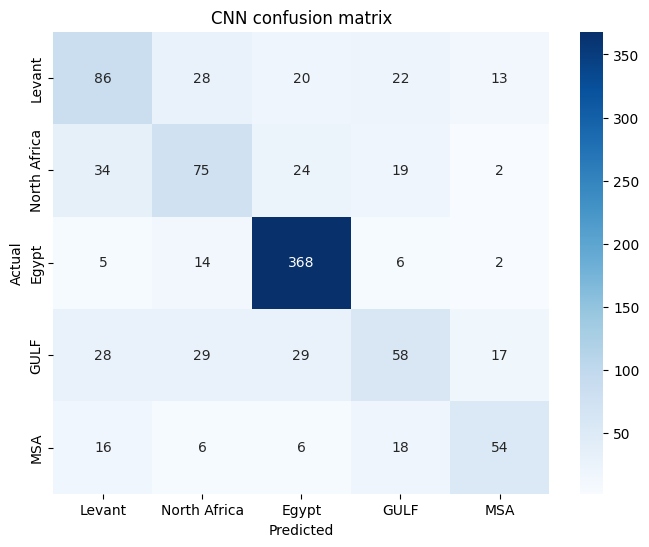

In [ ]:
# running the training 10 times to get the best model
# This code snippet was supported by AI
num_runs = 10
best_acc_overall = 0
best_preds = None
best_targets = None
best_model_state = None

for run in range(num_runs):
    print("")
    print(f"Run {run + 1} begins")

    model = DialectCNN_Simple(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        pad_idx=pad_idx
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_val = 999999
    wait = 0

    for epoch in range(epochs):
        train_loss, train_acc, train_f1 = train(
            model,
            train_loader,
            loss_fn,
            optimizer,
            device
        )
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, loss_fn, device)
        print(f"Epoch {epoch + 1}   val acc {val_acc}")

        if val_loss < best_val:
            best_val = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    test_loss, test_acc, test_f1, preds, targets = evaluate(model, test_loader, loss_fn, device)
    print(f"Run {run + 1} test acc {test_acc}")

    if test_acc > best_acc_overall:
        best_acc_overall = test_acc
        best_preds = preds
        best_targets = targets
        best_model_state = model.state_dict()


print("")
print("Best accuracy across all runs", best_acc_overall)

best_model = DialectCNN_Simple(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    pad_idx=pad_idx
).to(device)

temp_input = torch.randint(0, vocab_size, (1, max_len)).to(device)
_ = best_model(temp_input)

best_model.load_state_dict(best_model_state)

test_loss, test_acc, test_f1, preds, targets = evaluate(
    best_model,
    test_loader,
    loss_fn,
    device
)

print("")
print("Best model results")
print("Accuracy", test_acc)
print("Macro F1", test_f1)

cm = confusion_matrix(targets, preds)
print("Confusion matrix")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN confusion matrix")
plt.show()




# 3. Pre Trained model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("morit/arabic_xlm_xnli")
model = AutoModelForSequenceClassification.from_pretrained("morit/arabic_xlm_xnli")
model.eval()


tokenizer_config.json:   0%|          | 0.00/524 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
candidate_labels = ["Levant dialect", "North Africa dialect", "Egypt dialect", "Gulf dialect", "MSA dialect"]

# the manual zero shot was supported by AI
def manual_zero_shot(text, labels):
    ent_scores = []

    for label in labels:
        hypothesis = f"This text is written in {label}."

        inputs = tokenizer(
            text,
            hypothesis,
            return_tensors="pt",
            truncation=True,
            max_length=512
        )

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

        entail_logit = logits[:, 2]
        ent_scores.append(entail_logit.item())

    probs = F.softmax(torch.tensor(ent_scores), dim=0)
    predicted = labels[torch.argmax(probs)]

    return predicted, probs

In [ ]:
pred, probs = manual_zero_shot("النص هنا", candidate_labels)
print(pred)
print(probs)

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

North Africa dialect
tensor([0.2120, 0.2472, 0.2007, 0.1961, 0.1440])


In [ ]:
sample_df = test_df.sample(200, random_state = 42)

preds = []
for t in sample_df["Text"]:
    predicted_label, probs = manual_zero_shot(t, candidate_labels)
    preds.append(predicted_label)


In [ ]:
text_to_id = {
    "Levant dialect": 0,
    "North Africa dialect": 1,
    "Egypt dialect": 2,
    "Gulf dialect": 3,
    "MSA dialect": 4
}


In [ ]:
pred_ids = [text_to_id[p] for p in preds]
true_ids = sample_df["label"].tolist()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("XLM accuracy", accuracy_score(true_ids, pred_ids))
print("XLM macro F1", f1_score(true_ids, pred_ids, average = "macro"))





XLM accuracy 0.21
XLM macro F1 0.1679075046983757


Confusion matrix
[[ 1 21  5  9  0]
 [ 0 21  8  5  0]
 [ 4 50 11 14  0]
 [ 2 14  2  8  0]
 [ 1 12  8  3  1]]


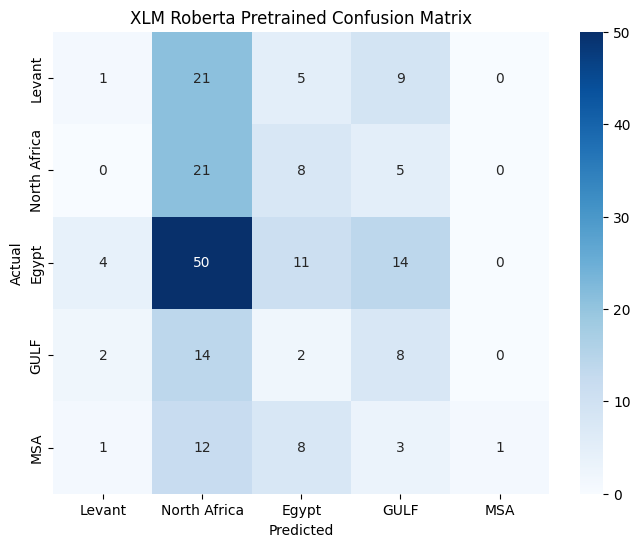

In [ ]:
cm = confusion_matrix(true_ids, pred_ids )
print("Confusion matrix")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XLM Roberta Pretrained Confusion Matrix")
plt.show()